In [1]:
import numpy as np
import gym
from pg import *
import matplotlib.pyplot as plt
from matplotlib import animation
%matplotlib inline
from JSAnimation.IPython_display import display_animation
from IPython.display import display
import time

In [2]:
%load_ext autoreload
%autoreload 2

### Step-wise Importance Sampline
### Step-wise weighted Importance Sampling
### Regression Estimator
### Doubly Robust Estimator
### Doubly Robust Estimator with constant baseline

In [3]:
def rounding_state(ob, rounding_factor):
    return np.round(ob*rounding_factor)

In [4]:
def do_episode(env, policy, max_pathlength, discount, path_baseline, rounding_factor):
    """
    Simulate the env and policy for max_pathlength steps
    """
    present_state = env.reset()

    obs = []
    actions = []
    rewards = []

    for _ in xrange(max_pathlength):
        action = policy.act(present_state)
        for _ in range(4):
            next_state, reward, done, _ = env.step(action)

        obs.append(rounding_state(present_state, rounding_factor))
        actions.append(action)
        rewards.append(reward)

        present_state = next_state

        if done:
            break
            
    if path_baseline:
        baseline = path_baseline.predict({"observations" : np.array(obs), 
                                          "actions" : np.array(actions), 
                                          "rewards" : np.array(rewards)})
        advantages = []

    returns = []
    return_so_far = 0
    for t in xrange(len(rewards) - 1, -1, -1):
        return_so_far = rewards[t] + discount * return_so_far
        returns.append(return_so_far)
        if path_baseline:
            advantage = return_so_far - baseline[t]
            advantages.append(advantage)
    # The returns and advantages are stored backwards in time, so we need to revert it
    returns = returns[::-1]
    if path_baseline:
        advantages = advantages[::-1]

    if path_baseline:
        return {"observations" : np.array(obs), "actions" : np.array(actions), "rewards" : np.array(rewards),
                "returns" : np.array(returns), "advantages" : advantages }
    else:
        return {"observations" : np.array(obs), "actions" : np.array(actions), "rewards" : np.array(rewards),
                "returns" : np.array(returns)}

def rollouts(env, policy, max_pathlength, number_of_paths, discount, path_baseline, rounding_factor):
    paths = []
    for _ in range(number_of_paths):
        path = do_episode(env, policy, max_pathlength, discount, path_baseline, rounding_factor)
        paths.append(path)
    if path_baseline:
        path_baseline.fit(paths)
    return paths


### Fitted Q-Learning

In [5]:
class FittedQAgent(object):
    """
    Agent implementing tabular Q-learning.
    """

    def __init__(self, observation_space, action_space, **userconfig):
        self.observation_space = observation_space
        self.action_space = action_space
        self.action_n = action_space.n
        self.config = {
            "init_mean" : 0.0,      # Initialize Q values with this mean
            "init_std" : 0.0,       # Initialize Q values with this standard deviation
            "learning_rate" : 0.1,
            "eps": 0.05,            # Epsilon in epsilon greedy policies
            "discount": 0.95,
            "n_episodes": 1000,    # Number of episodes
            "n_itr": 10}        # Maximum number of iteration
        self.config.update(userconfig)
        self.q = defaultdict(lambda: self.config["init_std"] * np.random.randn(self.action_n) +
                             self.config["init_mean"])

    def learn(self, data):
        config = self.config
        q = self.q
        alpha = config["learning_rate"]
        gamma = config["discount"]
        max_iteration = config["n_itr"]
        errors = []
        for n_itr in xrange(max_iteration):
            for episode in data:
                observations = episode["observations"]
                actions = episode["actions"]
                rewards = episode["rewards"]
                present_state = observations[0]
                for n in xrange(len(observations)-1): # Double check it
                    action = actions[n]
                    next_state, reward = observations[n+1], rewards[n]
                    done = (n == len(observations)-2)
                    future = 0.0
                    if not done:
                        future = np.max(q[tuple(next_state)])
                    q[tuple(present_state)][action] =  (((1 - alpha) * q[tuple(present_state)][action])
                                                 + (alpha * (reward + gamma * future)))
                    present_state = next_state
                
            if n_itr == 0:
                new_q = np.concatenate([x[1] for x in sorted(self.q.items())])
            else:
                pre_q, new_q = new_q, np.concatenate([x[1] for x in sorted(self.q.items())])
                errors.append(np.mean(np.abs(pre_q - new_q)))
        return errors

In [6]:
class RandomDiscreteActionChooser(object):
    def __init__(self, n_actions):
        self.n_actions = n_actions
    def act(self, observation):
        return np.random.randint(0, self.n_actions)

In [7]:
class FixedPolicy(object):
    def __init__(self, policy, rounding_factor):
        self.policy = policy
        self.rounding_factor = rounding_factor
        
    def cat_sample(self, prob_k):
        """
        Sample from categorical distribution
        Each row specifies class probabilities
        """
        assert np.allclose(prob_k.sum(),1)
        csprob_k = np.cumsum(prob_k)
        r = np.random.rand()
        for (k,csprob) in enumerate(csprob_k):
            if csprob > r:
                out = k
                break
        return out

    def act(self, observation):
        rounded_state = tuple(rounding_state(observation, self.rounding_factor))
        return self.cat_sample(self.policy[rounded_state])

In [8]:
def generate_pi_train(q_agent):
    pi_train = defaultdict(lambda: 1./3*np.ones(3))
    for key, value in q_agent.q.items():
        action = np.argmax(value)
        action_prob = np.zeros(3)
        action_prob[action] = 1
        pi_train[key] = action_prob
    return pi_train

In [9]:
def compute_value_function(policy, rounding_factor, gamma = 0.99, max_path_length = 100, path_n = 5000):
    data = rollouts(env, policy, max_path_length, path_n, gamma, None, rounding_factor)
    returns = [episode["returns"][0] for episode in data]
    return np.mean(returns) 

In [10]:
def generate_pi_1(pi_train, alpha):
    pi_1 = defaultdict(lambda: np.ones(3)/3.0)
    for key, value in pi_train.items():
        pi_1[key] = (1-alpha)*value + alpha*np.ones(3)/3.0
    return pi_1

In [11]:
def step_wise_is(pi_one, pi_zero, gamma, data, max_path_length = 100):
    V = []
    for episode in data:
        V_episode = 0
        observations = episode["observations"]
        actions = episode["actions"]
        rewards = episode["rewards"]
        gamma_i = 1
        rho = 1
        for i in range(len(observations)):
            state, action = tuple(observations[i]), actions[i]
            rho = rho*(pi_one[state][action]/pi_zero[state][action])
            if rho == 0:
                break
            V_episode += gamma_i*rho*rewards[i]
            gamma_i *= gamma

        V.append(V_episode)
    
    return np.mean(V), np.std(V)

In [12]:
def step_wise_weighted_is(pi_one, pi_zero, gamma, data, max_path_length = 100):
    # Calculate Weights
    H = max_path_length
    w = np.zeros(H, dtype="float")
    for episode in data:
        rho = 1
        observations = episode["observations"]
        actions = episode["actions"]
        for i in range(len(observations)):
            state, action = tuple(observations[i]), actions[i]
            rho = rho*(pi_one[state][action]/pi_zero[state][action])
            if rho == 0:
                break
            w[i] += rho
    w /= len(data) 
    V = []
    # Do Weighted Importance Sampling
    for episode in data:
        observations = episode["observations"]
        actions = episode["actions"]
        rewards = episode["rewards"]
        V_episode = 0        
        gamma_i = 1
        rho = 1
        for i in range(len(observations)):
            state, action = tuple(observations[i]), actions[i]
            rho = rho*(pi_one[state][action]/pi_zero[state][action])
            if rho == 0:
                break
            V_episode += gamma_i*rho*rewards[i]/w[i]
            gamma_i *= gamma
        V.append(V_episode)
    
    return np.mean(V), np.std(V)

In [28]:
def generate_q_agent(data_train = None, n_itr = 1):
    rounding_factor = np.array([2**6, 2**8])
    random_policy = RandomDiscreteActionChooser(env.action_space.n)
    plot = False
    if data_train is None:
        data_train = rollouts(env, random_policy, 100, 2000, 1, None, rounding_factor)
        plot = True
    qAgent = FittedQAgent(ob_space, ac_space, n_itr = n_itr)
    if plot:
        plt.plot(qAgent.learn(data_train))
        plt.xlabel("Number of Iterations")
        plt.ylabel("Error in Fitterd Q")
    else:
        qAgent.learn(data_train)
    return qAgent

In [14]:
def value_from_is():
    alphas = [0.0, 0.25, 0.5, 0.75, 1.00]
    rounding_factor = np.array([2**6, 2**8])
    random_policy = RandomDiscreteActionChooser(env.action_space.n)
    data_eval = rollouts(env, random_policy, 100, 5000, 0.99, None, rounding_factor)
    pi_train = generate_pi_train(qAgent)
    V_IS_mean, V_IS_std = [], []
    for alpha in alphas:
        pi_1 = generate_pi_1(pi_train, alpha)
        pi_0 = defaultdict(lambda : np.ones(3, dtype=float)/3)
        V_mean, V_std = step_wise_is(pi_1, pi_0, gamma = 0.99, data = data_eval)
        V_IS_mean.append(V_mean)
        V_IS_std.append(V_std)
    plt.figure(figsize = (15, 5))
    plt.subplot(1,2,1)
    plt.plot(alphas, V_IS_mean)
    plt.xlabel("alpha")
    plt.ylabel("mean of action Value of IS")
    plt.subplot(1, 2, 2)
    plt.plot(alphas, V_IS_std)
    plt.xlabel("alpha")
    plt.ylabel("variance of action Value of IS")
    return V_IS_mean, V_IS_std

In [24]:
def value_from_wis():
    rounding_factor = np.array([2**6, 2**8])
    alphas = [0.0, 0.25, 0.5, 0.75, 1.00]
    random_policy = RandomDiscreteActionChooser(env.action_space.n)
    max_pathlength = 100
    data_eval = rollouts(env, random_policy, max_pathlength, 5000, 0.99, None, rounding_factor)
    pi_train = generate_pi_train(qAgent)
    V_WIS_mean, V_WIS_std = [], []
    for alpha in alphas:
        pi_1 = generate_pi_1(pi_train, alpha)
        pi_0 = defaultdict(lambda : np.ones(3, dtype=float)/3)
        V_mean, V_std = step_wise_weighted_is(pi_1, pi_0, gamma = 0.99, data = data_eval, 
                                              max_path_length=max_pathlength)
        V_WIS_mean.append(V_mean)
        V_WIS_std.append(V_std)
    plt.figure(figsize = (15, 5))
    plt.subplot(1,2,1)
    plt.plot(alphas, V_WIS_mean, marker = "H")
    plt.xlabel("alpha")
    plt.ylabel("mean of action Value of WIS")
    plt.subplot(1, 2, 2)
    plt.plot(alphas, V_WIS_std)
    plt.xlabel("alpha")
    plt.ylabel("variance of action Value of WIS")
    return V_WIS_mean, V_WIS_std

In [16]:
def ground_truth(alphas = [0.0, 0.25, 0.5, 0.75, 1.0]):
    rounding_factor = np.array([2**6, 2**8])
    ground_truth_V = []
    pi_train = generate_pi_train(qAgent)
    for alpha in alphas:
        pi_1 = generate_pi_1(pi_train, alpha)
        fixed_policy = FixedPolicy(pi_1, rounding_factor)
        v = compute_value_function(fixed_policy, rounding_factor = rounding_factor,
                                   gamma = 0.99, max_path_length = 100, path_n = 5000)
        ground_truth_V.append(v)
    plt.plot(alphas, ground_truth_V)
    plt.xlabel("alpha")
    plt.ylabel("True Return")
    return ground_truth_V

In [ ]:
def rmse_plot_is():
    rounding_factor = np.array([2**6, 2**8])
    data_size = [10, 100, 1000, 2000, 3000, 4000, 5000]
    n_trial = 10
    pi_train = generate_pi_train(qAgent)
    random_policy = RandomDiscreteActionChooser(env.action_space.n)
    pi_0 = defaultdict(lambda : np.ones(3, dtype="float")/3)
    plt.figure(figsize=(15, 10))
    for i_alpha, alpha in enumerate([0.0, 0.25, 0.5, 0.75]):
        print "RUNNING Experiment with alpha = {}".format(alpha)
        pi_1 = generate_pi_1(pi_train, alpha)
        errors = np.zeros_like(data_size, dtype="float")
        for _ in range(n_trial):        
            data_eval_all = rollouts(env, random_policy, 100, 5000, 0.99, None, rounding_factor)
            for i, n in enumerate(data_size):
                V_mean, V_std = step_wise_is(pi_1, pi_0, gamma = 0.99, data = data_eval_all[:n])
                relative_error = (V_mean - ground_truth_V[i_alpha])/ground_truth_V[i_alpha]
                errors[i] = errors[i] + relative_error**2
        errors = np.sqrt(errors/n_trial) 
        plt.subplot(2, 2, i_alpha+1)
        plt.plot(data_size, np.log10(errors), marker='o')
        plt.xlabel("|D_test|")
        plt.ylabel("Log10 of relative RMSE")
        plt.ylim([-2, 0])
        plt.title(r"${0}\pi_{1} + {2} \pi_0 $".format(1-alpha, '{train}', alpha))
    return np.log10(errors)            

In [ ]:
def rmse_plot_wis():
    rounding_factor = np.array([2**6, 2**8])
    data_size = [10, 100, 1000, 2000, 3000, 4000, 5000]
    n_trial = 10
    pi_train = generate_pi_train(qAgent)
    random_policy = RandomDiscreteActionChooser(env.action_space.n)
    pi_0 = defaultdict(lambda : np.ones(3, dtype="float")/3)
    plt.figure(figsize=(15, 10))
    for i_alpha, alpha in enumerate([0.0, 0.25, 0.5, 0.75]):
        print "RUNNING Experiment with alpha = {}".format(alpha)
        pi_1 = generate_pi_1(pi_train, alpha)
        errors = np.zeros_like(data_size, dtype="float")
        for _ in range(n_trial):        
            data_eval_all = rollouts(env, random_policy, 100, 5000, 0.99, None, rounding_factor)
            for i, n in enumerate(data_size):
                V_mean, V_std = step_wise_weighted_is(pi_1, pi_0, gamma = 0.99, data = data_eval_all[:n])
                relative_error = (V_mean - ground_truth_V[i_alpha])/ground_truth_V[i_alpha]
                errors[i] = errors[i] + relative_error**2
        errors = np.sqrt(errors/n_trial) 
        plt.subplot(2, 2, i_alpha+1)
        plt.plot(data_size, np.log10(errors), marker='o')
        plt.xlabel("|D_test|")
        plt.ylabel("Log10 of relative RMSE")
        plt.ylim([-2, 0])
        plt.title(r"${0}\pi_{1} + {2} \pi_0 $".format(1-alpha, '{train}', alpha))
    return np.log10(errors)

In [19]:
def prob_distribution(a_list):
    dist = defaultdict(lambda: 0)
    len_a_list = float(len(a_list))
    for elem in a_list:
        dist[elem] += 1
    for key, value in dist.items():
        dist[key] = value/len_a_list
    return dist

def train_MDP(data):
    mdp = defaultdict(lambda : [[], []])
    for episode in data:    
        observations, actions, rewards = episode["observations"], episode["actions"], episode["rewards"]
        for state, action, next_state, reward in zip(observations[:-1], actions[:-1], 
                                                     observations[1:], rewards[:-1]):
            v = mdp[state[0], state[1], action]
            v[0].append(tuple(next_state))
            v[1].append(reward)
            
    for key, value in mdp.items():
        mdp[key] = [prob_distribution(value[0]), np.mean(value[1])]
    
    return mdp

def reg(data, pi_one, gamma):
    v = []
    mdp = train_MDP(data)
    V = {}
    Q = {}
    for episode in data:
        actions, rewards, observations = episode["actions"], episode["rewards"], episode["observations"]
        actions, rewards, observations = actions[:-1][::-1], rewards[:-1][::-1], observations[:-1][::-1]
        default_val = 0
        for h, state, action in zip(range(len(observations)), observations, actions):
            next_states_probs = mdp[state[0], state[1], action][0].items()
            reward = mdp[state[0], state[1], action][1]
            Q[state[0], state[1], action] = reward + gamma*sum(prob * V.get(next_state, default_val) 
                                                               for next_state, prob in next_states_probs)
            default_val = -1 + gamma * default_val  ## updating the default value for action-values
            actions_prob = pi_one[state[0], state[1]]
            q_values = np.array([Q.get((state[0], state[1], a), default_val) for a in [0, 1, 2]])
            V[state[0], state[1]] = q_values.dot(actions_prob)
            
        v.append(V[state[0], state[1]])
    return V, Q, np.mean(v), np.std(v)

In [20]:
def value_from_reg(alphas = [0.0, 0.25, 0.5, 0.75, 1.00], d_test_size = 5000):
    rounding_factor = np.array([2**6, 2**8])
    random_policy = RandomDiscreteActionChooser(env.action_space.n)
    data_eval = rollouts(env, random_policy, 100, d_test_size, 0.99, None, rounding_factor)
    pi_train = generate_pi_train(qAgent)
    V_reg_mean, V_reg_std = [], []
    for alpha in alphas:
        pi_1 = generate_pi_1(pi_train, alpha)
        _, _, V_mean, V_std = reg(pi_one = pi_1, gamma = 0.99, data = data_eval)
        V_reg_mean.append(V_mean)
        V_reg_std.append(V_std)
    plt.figure(figsize = (15, 5))
    plt.subplot(1,2,1)
    plt.plot(alphas, V_reg_mean)
    plt.xlabel(r"$\alpha$")
    plt.ylabel("mean of action Value of Regression")
    plt.subplot(1, 2, 2)
    plt.plot(alphas, V_reg_std)
    plt.xlabel(r"$\alpha$")
    plt.ylabel("variance of action Value of reg")
    return V_reg_mean, V_reg_std

In [38]:
def rmse_plot_reg(alphas = [0.0, 0.25, 0.5, 0.75], n_trial = 50, 
                  data_size = [10, 100, 1000, 2000, 3000, 4000, 5000], 
                  ground_truth_V = ground_truth_V):
    rounding_factor = np.array([2**6, 2**8])
    pi_train = generate_pi_train(qAgent)
    random_policy = RandomDiscreteActionChooser(env.action_space.n)
    plt.figure(figsize=(15, 10))
    for i_alpha, alpha in enumerate(alphas):
        print "RUNNING Experiment with alpha = {}".format(alpha)
        pi_1 = generate_pi_1(pi_train, alpha)
        errors = np.zeros_like(data_size, dtype="float")
        for _ in range(n_trial):        
            data_eval_all = rollouts(env, random_policy, 100, 5000, 0.99, None, rounding_factor)
            for i, n in enumerate(data_size):
                _, _, V_mean, V_std = reg(pi_one = pi_1, gamma = 0.99, data = data_eval_all[:n])
                relative_error = (V_mean - ground_truth_V[i_alpha])/ground_truth_V[i_alpha]
                errors[i] = errors[i] + relative_error**2
        errors = np.sqrt(errors/n_trial) 
        plt.subplot(2, 2, i_alpha+1)
        plt.plot(data_size, np.log10(errors), marker='o')
        plt.xlabel(r"$|D_{test}|$")
        plt.ylabel("Log10 of relative RMSE ")
        plt.ylim([-2, 0])
        plt.title(r"${0}\pi_{1} + {2} \pi_0 $".format(1-alpha, '{train}', alpha))
    return errors

In [22]:
env = gym.make("MountainCar-v0")
ob_space = env.observation_space
ac_space = env.action_space

INFO:gym.envs.registration:Making new env: MountainCar-v0
[2016-08-30 19:14:32,594] Making new env: MountainCar-v0


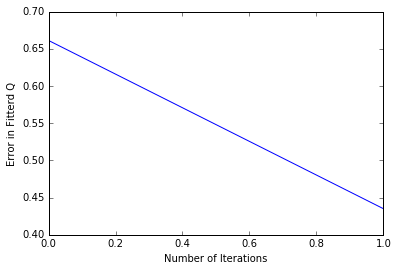

In [31]:
qAgent = generate_q_agent(n_itr = 3)

### Ground Truth as a function of  $\alpha$

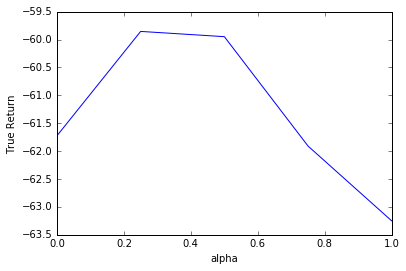

In [32]:
ground_truth_V = ground_truth()

### STEP WISE IS

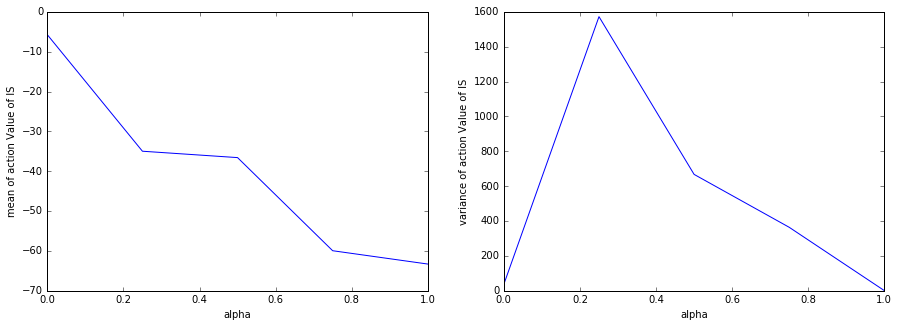

In [34]:
V_IS = value_from_is()

### Inference from the above plot:

1. Why does the variance in IS increases with $\alpha$ and suddenly drop to zero for $\alpha = 1$?
    *  When $\alpha = 0$, our policy is essentially deterministic. Therefore the most of the importance sampling terms can become zero, consequently we see a low varaince. Moreover, when $\alpha = 1$, both target and behavior policy become same, hence the importance sampling terms become $1$ and we do not see any variance.
    

### Step-wise Weighted IS

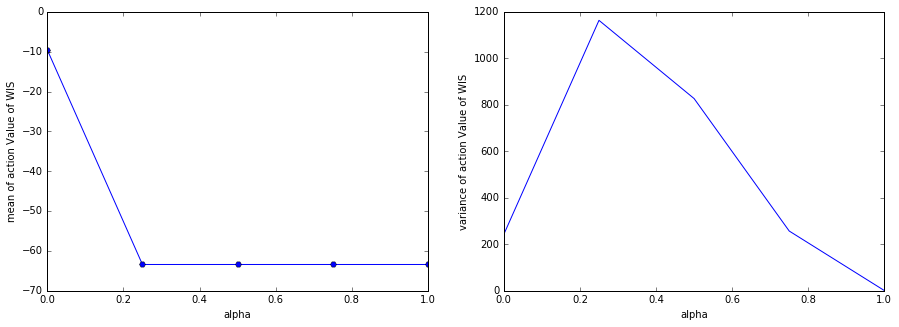

In [35]:
V_WIS = value_from_wis()

### Inference from the above plot:

1. Why does the variance in Weighted Importance Sampling (WIS) increases with $\alpha$ and suddenly drop to zero for $\alpha = 1$?
    * The same argument that we gave for IS case is applicable here. 
    
2. Whys does the WIS give almost same estimate of value function for all policies with $\alpha > 0$?
    * The formula for WIS estimate is
    $$
     \sum_{i=1}^D \sum_{t=1}^H \gamma^{t-1} \frac{\rho^i_{1:t} r_t^i}{\sum_{j=1}^D \rho^j_{1:t}}.
    $$
    
    The only justification that I can think of this phenomenon is that the factor $\sum_{i=1}^D \frac{\rho^i_{1:t} r_t^i}{\sum_{j=1}^D \rho^j_{1:t}}$ is coming same for all probability distibutions corresponding to different $\alpha$. Note that the reward $r^i_t = -1 \;\; \forall\;\; i, t$. Consequently,  
    $$ 
    \sum_{i=1}^D \frac{\rho^i_{1:t} r_t^i}{\sum_{j=1}^D \rho^j_{1:t}} = -1
    $$
    Consequently, the answer that we should get is $\left.\frac{1-\gamma^{100}}{1 - \gamma}\right|_{\gamma = 0.99} = 63.396$. The reason that we got higher reward for $\alpha = 0.0$, because importance sampling terms quickly becomes 0 after around 10 rollouts.
    Since the policy $\pi_0$ is uniform, I checked that most rollout (more than 99%) terminates because the maximum path length for the rollouts are reached.

### REGRESSION

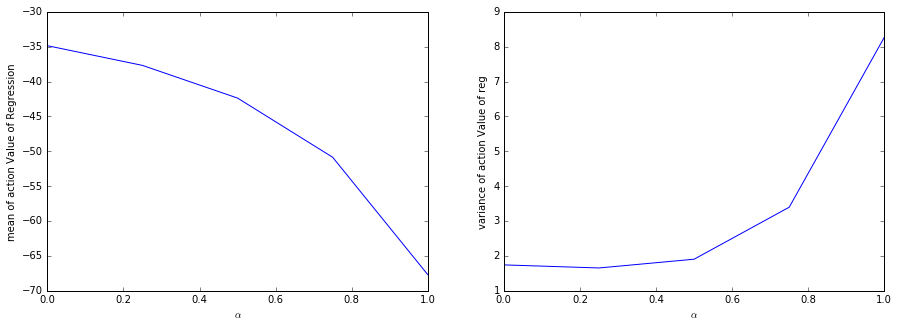

In [36]:
V_reg = value_from_reg()

### Observations:

1. Variance in Regression Estimate first decreases with $\alpha$, reach a minimum, and  then increases with $\alpha$.
    * There are two opposing factors. As $\alpha$ increases, the target policy become more random while at the same time the target policy goes more closer to the behavior policy. This is the reason for the above graph.

### Relative RMSE for Step-wise IS

RUNNING Experiment with alpha = 0.0
RUNNING Experiment with alpha = 0.25
RUNNING Experiment with alpha = 0.5
RUNNING Experiment with alpha = 0.75


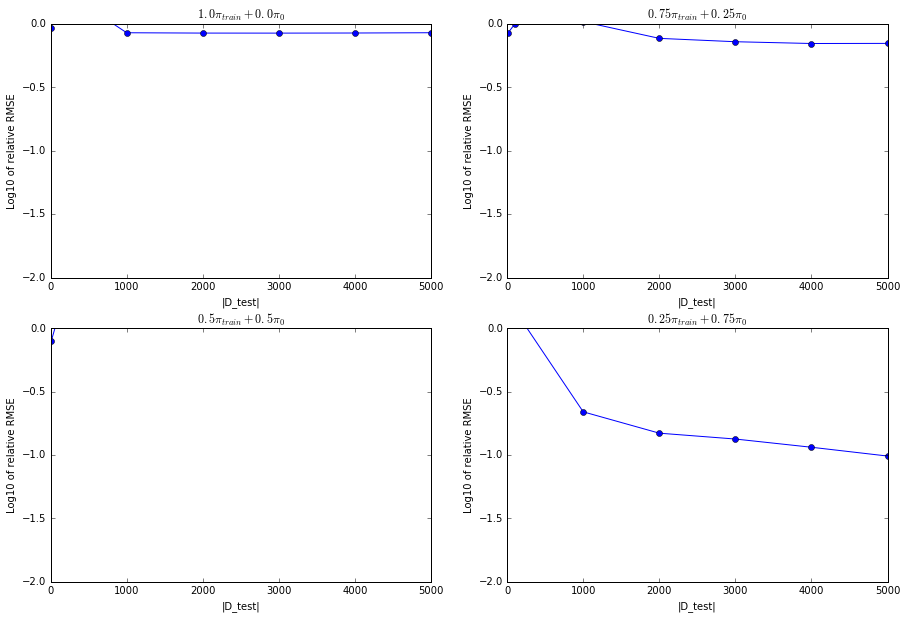

In [39]:
errors_IS = rmse_plot_is()

### Inference from the above graph

1. Why does the RMSE error reduces as $\alpha$ increases?
    * As $\alpha$ increases, target policy reaches close to the behavior policy and important sampling ratio becomes closer to one for all actions, consequently, we get better estimate of value funciton with lower variance.
    
    
2. Why does the RMSE estimate for a given $\alpha$ becomes better as $|D_{test}|$ increases?
    * IS is an unbiased estimator but with high variance. As $|D_{test}|$ increases, becasue of the law of large number, we reduces the varainces, consequently, RMSE also reduces.
    
    
3. Why does the RMSE estimate are worst for $\alpha = 0.25$?
    * Among all the cases considered, $\pi_1(0.25)$ is the first stochastic policy that is the farthest from the behavior policy $\pi_0$, therefore, we are getting the worst RMSE estimate for $\pi_1(0.25)$ while using IS.

### Relative RMSE for Step-wise weighted IS

RUNNING Experiment with alpha = 0.0
RUNNING Experiment with alpha = 0.25
RUNNING Experiment with alpha = 0.5
RUNNING Experiment with alpha = 0.75


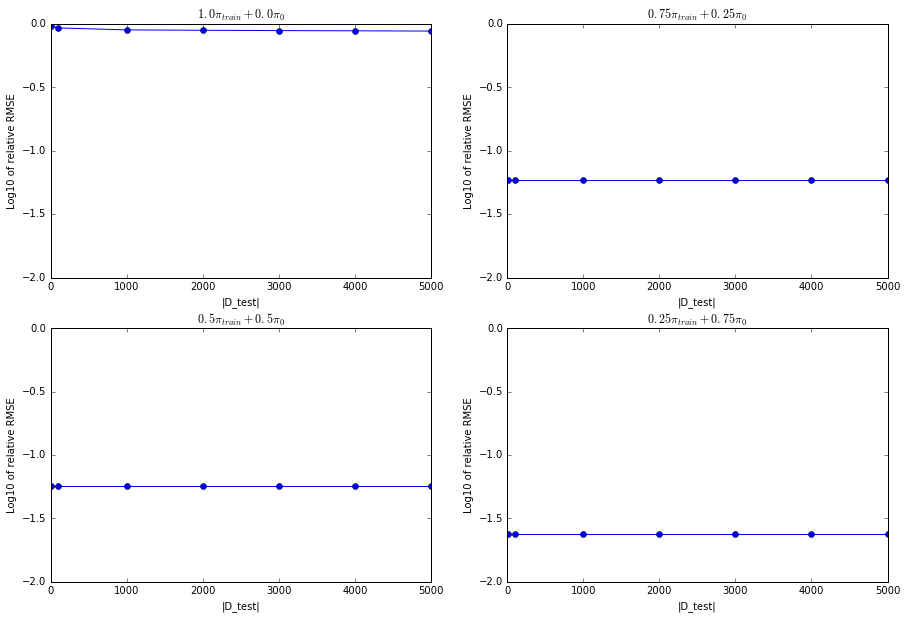

In [40]:
errors_WIS = rmse_plot_wis()

### Inference from the above graph

1. As we have argued earlier, the value estimate using the WIS will be a constant for any stochastic policy that satisfies the following conditions:
    * It gives non-zero probailities for all actions, 
    * The immediate rewards are constant during the rollout, 
    * each rollout is of the same size.
    
Consequently, we see a cosntant line in the above curve.

### Relative RMSE with Regression

RUNNING Experiment with alpha = 0.0
RUNNING Experiment with alpha = 0.25
RUNNING Experiment with alpha = 0.5
RUNNING Experiment with alpha = 0.75


array([ 0.11590465,  0.23075356,  0.24831609,  0.22688434,  0.20872619,
        0.19341989,  0.1801157 ])

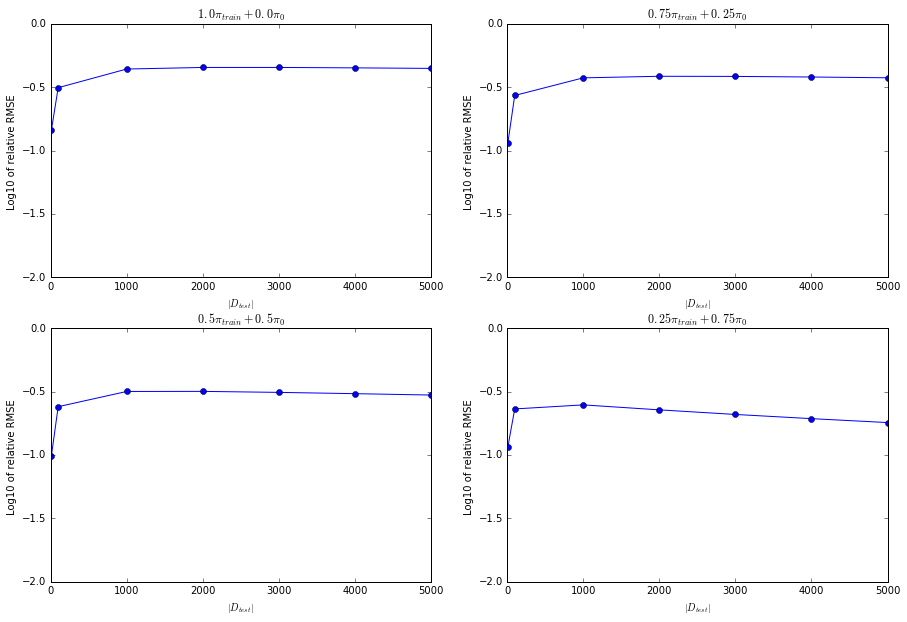

In [41]:
rmse_plot_reg()

1. Why RMSE first reduces as $\alpha$ increases and then decreases for $\alpha = 0.75$?
    * The RMSE decreases becauses the target policy becomes closer to the behavior policy. However, as we noted previously that the variance of the regression estimate increases as $\alpha$ increases. That could be the one possible reason that we see that the RMSE is high for $\alpha = 0.75$. ** However, the figure plotted in the paper does not show this pattern. In the paper, the RMSE reduces consistently as $\alpha$ increases. **

### Doubly Robust Estimator

# Check the accuracy of default value in DR?

In [ ]:
def value_from_DR():
    rounding_factor = np.array([2**6, 2**8])
    gamma = 1
    alphas = [0.0, 0.25, 0.5, 0.75, 1.00]
    random_policy = RandomDiscreteActionChooser(env.action_space.n)
    data_DR = rollouts(env, random_policy, 100, 5000, 0.99, None, rounding_factor)
    n_regs = [10, 100, 1000, 2000, 3000, 4000, 4990]
    policy_opt = generate_pi_train(qAgent)
    plt.figure(figsize = (20, 6))
    for i_reg, n_reg in enumerate(n_regs):
        data_DR_reg = data_DR[:n_reg]
        data_DR_test = data_DR[n_reg:]
        V_DR_mean, V_DR_std = [], []
        policy_0 = defaultdict(lambda : np.ones(3, dtype=float)/3)

        for alpha in alphas:
            V_dr_tot = []
            policy_1 = generate_pi_1(policy_opt, alpha)
            train_v, train_q, _, _ = reg(data = data_DR_reg, pi_one = policy_1, gamma = 0.99)
            for episode in data_DR_test:
                V_dr = 0
                actions, rewards, observations = episode["actions"], episode["rewards"], episode["observations"]
                actions, rewards, observations = actions[::-1], rewards[::-1], observations[::-1]
                default_v = 0
                for h, state, action, reward in zip(range(len(observations)), observations, 
                                                    actions, rewards):
                    rho = policy_1[tuple(state)][action]/policy_0[tuple(state)][action] # importance sampling
                    V_dr = (train_v.get(tuple(state), default_v) 
                            + rho*(reward 
                                   + gamma*V_dr 
                                   - train_q.get((state[0], state[1], action), default_v)))
                    default_v = -1 + gamma*default_v   # updating the default value of Markov Process
                V_dr_tot.append(V_dr)
            V_DR_mean.append(np.mean(V_dr_tot))
            V_DR_std.append(np.std(V_dr_tot))
        ## Mean Plotting
        plt.subplot(2, 7, i_reg+1)
        plt.plot(alphas, V_DR_mean)
        if not i_reg%7:
            plt.ylabel("mean of value estimate of DR")
        plt.title("data size = {}".format(n_reg))
        ## Deviation Plotting
        plt.subplot(2, 7, i_reg+8)
        plt.plot(alphas, V_DR_std)
        plt.xlabel(r"$\alpha$")
        if not i_reg%7:
            plt.ylabel("standard deviation in value estimate of DR")
        plt.title("data size = {}".format(n_reg))
    plt.tight_layout()
    return V_DR_mean, V_DR_std

In [ ]:
v_DR_mean, v_DR_std = value_from_DR()

In [ ]:
#default_v = 0
v_DR_mean, v_DR_std = value_from_DR()

### Inference from the above graphs

1. Why does the DR estimator has a huge standard deviations?
    * The recursive equation for the DR estimator is 
    $$
    V^{H+1-t}_{DR} := \hat{V}(s_t) + \rho_t(r_t + \gamma V^{H-t}_{DR} - \hat{Q}(s_t, a_t)) \forall t \in \{1, 2, \cdots, H\}
    $$
    where $V^0_{DR} = 0$
    
    We can write the final DR estimate as 
    $$
    V^H_{DR} = \sum_{t=1}^H \rho_{1:t}\gamma^{t-1} r_t +  \rho_{1:t-1}\gamma^{t-1}\left(\hat{V}(s_t) - \rho_t\hat{Q}(s_t, a_t)\right)
    $$
    Because of the presence of the importance sampling ratio in both the terms in the right hand side, we see a huge variance in the DR estimator.
    
2. What are the reasons behind the compratively low variance at $\alpha = 0$ and $\alpha = 1$?
    * For $\alpha = 0$, the target policy is a determinstic policy, consequently, most of importance sampling ratio terms are $0$, therefore, we see less variance.
    * For $\alpha = 1$, the importance sampling ratio becomes 1.
    
3. Why does the estimate become progressively better (both in biases and variance) as the data size for the regression increases?
    * As the data size increases, the regression estimate becomes better. As shown in the paper, the variance of the DR estimator depends on $|Q - \hat{Q}|$. Since, the estimate becomes better, the variance in the DR reduces with the data size.
    
4. Why does the estimate higly depends on the default value when the data size for the regression is small?
    * When the data size for the regression is small, there are many states for which we don't have any estimate. Consequently, in the DR estimate we have to use the default value that affect the estimate.
 

In [ ]:
def value_estimate_DR(data_test, train_v, train_q, policy_1, policy_0, gamma):
    """
    gives the value estimate of DR estimator using the State Value Function `train_v` 
    and State-Action Value Function `train_q`
    """
    V_dr_tot = []
    for episode in data_test:
        V_dr = 0
        actions, rewards, observations = episode["actions"], episode["rewards"], episode["observations"]
        actions, rewards, observations = actions[::-1], rewards[::-1], observations[::-1]
        default_v = 0
        for h, state, action, reward in zip(range(len(observations)), observations, 
                                            actions, rewards):
            rho = policy_1[tuple(state)][action]/policy_0[tuple(state)][action]
            V_dr = (train_v.get(tuple(state), default_v) 
                    + rho*(reward 
                           + gamma*V_dr 
                           - train_q.get((state[0], state[1], action), default_v)))
            default_v = -1 + gamma*default_v
        V_dr_tot.append(V_dr)
    return np.mean(V_dr_tot), np.std(V_dr_tot)

In [ ]:
def value_DR_ntests(data, n_tests, policy_1, policy_0, gamma):
    """
    Give the errors in estimating value functions using DR estimator
    """
    
    V_dr_agg = []
    V_reg_agg = []
    V_is_agg = []
    V_wis_agg = []
    for n_test in n_tests:          
        data_DR_reg = data[n_test:]
        data_DR_test = data[:n_test]
        train_v, train_q, v_reg_mean, v_reg_std = reg(data = data_DR_reg, pi_one = policy_1, gamma = 0.99)     
        v_dr_mean, v_dr_std = value_estimate_DR(data_DR_test, train_v, train_q, policy_1, policy_0, gamma = 0.99) 
        ### importance sampling and weighted importance sampling
        v_is_mean, _ = step_wise_is(policy_1, policy_0, gamma = 0.99, data = data_DR_test)
        v_wis_mean, _ = step_wise_weighted_is(policy_1, policy_0, gamma = 0.99, data = data_DR_test)
        V_dr_agg.append(v_dr_mean)
        V_reg_agg.append(v_reg_mean)
        V_is_agg.append(v_is_mean)
        V_wis_agg.append(v_wis_mean)
    return V_dr_agg, V_reg_agg, V_is_agg, V_wis_agg
    

In [ ]:
def rmse_plot_DR():
    rounding_factor = np.array([2**6, 2**8])
    n_trial = 50
    gamma = 0.99
    alphas = [0.0, 0.25, 0.5, 0.75]
    n_tests = [10, 100, 1000, 2000, 3000, 4000, 4500, 4900]
    random_policy = RandomDiscreteActionChooser(env.action_space.n)
    policy_train = generate_pi_train(qAgent)
    policy_0 = defaultdict(lambda : np.ones(3, dtype=float)/3)
    
    plt.figure(figsize=(15, 8))
    for i_alpha, alpha in enumerate(alphas):
        print "RUNNING Experiment with alpha = {}".format(alpha)
        policy_1 = generate_pi_1(policy_train, alpha)
        errors_dr = np.zeros_like(n_tests, dtype="float")
        errors_reg = np.zeros_like(n_tests, dtype="float")
        errors_is = np.zeros_like(n_tests, dtype="float")
        errors_wis = np.zeros_like(n_tests, dtype="float")
        for _ in range(n_trial):
            data_DR = rollouts(env, random_policy, 100, 5000, 0.99, None, rounding_factor)
            V_drs, V_regs, V_is, V_wis = value_DR_ntests(data_DR, n_tests, policy_1, policy_0, gamma)
            relative_error_dr = (np.array(V_drs) - ground_truth_V[i_alpha])/ground_truth_V[i_alpha]
            relative_error_reg = (np.array(V_regs) - ground_truth_V[i_alpha])/ground_truth_V[i_alpha]
            relative_error_is = (np.array(V_is) - ground_truth_V[i_alpha])/ground_truth_V[i_alpha]
            relative_error_wis = (np.array(V_wis) - ground_truth_V[i_alpha])/ground_truth_V[i_alpha]
            errors_dr += relative_error_dr**2
            errors_reg += relative_error_reg**2
            errors_is += relative_error_is**2
            errors_wis += relative_error_wis**2
        errors_dr = np.sqrt(errors_dr/n_trial) 
        errors_reg = np.sqrt(errors_reg/n_trial) 
        errors_is = np.sqrt(errors_is/n_trial) 
        errors_wis = np.sqrt(errors_wis/n_trial)
        
        plt.subplot(2, 2, i_alpha+1)
        plt.plot(n_tests, np.log10(errors_is), marker='*')
        plt.plot(n_tests, np.log10(errors_wis), marker='+')
        plt.plot(n_tests, np.log10(errors_reg), marker='8')
        plt.plot(n_tests, np.log10(errors_dr), marker='s')

        plt.xlabel("|D_test|")
        plt.ylabel("Log10 of relative RMSE ")
        plt.ylim([-2, 0])
        plt.legend(["IS", "WIS", "REG", "DR"], loc = "lower right")
        plt.title(r"${0}\pi_{1} + {2} \pi_0 $".format(1-alpha, '{train}', alpha))
    return errors_dr, errors_reg

In [ ]:
import time
t = time.clock()
rmse_plot_DR()
print "time spent in running the simulation is {}".format(time.clock() - t)

### Inference from the above graph

1. For $\alpha = 1$, DR is performing better than all estimators. 

2. The performance of DR estimator consistently becomes worse as the size of regression data set reduces.

3. As $\alpha$ increses, the performance of IS becomes better than the Regression Method and DR. 

In [ ]:
rmse_plot_DR()

### Inference from the above graph

1. Why is DR performing better than Regression method when $D_{\text{test}}$ is small for $\alpha = \{0.0, 0.25\}$?

### Exercise 6.2

In [ ]:
def calculate_score(c, mu, sigma):
    return mu - c*sigma

In [ ]:
def compute_value_policy(policy):
    rounding_factor = np.array([2**6, 2**8])
    fixed_policy = FixedPolicy(policy, rounding_factor)
    v = compute_value_function(fixed_policy, rounding_factor = rounding_factor,
                                   gamma = 0.99, max_path_length = 100, path_n = 5000)
    return v

In [ ]:
def safe_policy_improvement():
    alphas = np.linspace(0, 1, 11)
    training_sizes = [0.2, 0.4, 0.6, 0.8]
    rounding_factor = np.array([2**6, 2**8])
    random_policy = RandomDiscreteActionChooser(env.action_space.n)
    data_sizes = [10, 100, 1000, 2000, 5000]
    value_imporvements = []
    for data_size in data_sizes:
        data_safe_policy = rollouts(env, random_policy, 100, data_size, 0.99, None, rounding_factor)
        pi_0 = defaultdict(lambda: np.ones(3, dtype=float)/3)
        value_random_policy = compute_value_policy(pi_0)
        cs = [0, 1, 2]
        rewards = np.zeros((len(training_sizes), len(alphas), len(cs))) 
        for i_train, training_size in enumerate(training_sizes):
            train_len = int(training_size*len(data_safe_policy))
            data_train, data_test = data_safe_policy[:train_len], data_safe_policy[train_len:]
            qAgent = generate_q_agent(data_train)
            pi_optimal = generate_pi_train(qAgent)
            for i_alpha, alpha in enumerate(alphas):
                pi_1 = generate_pi_1(pi_optimal, alpha)
                v_mean, v_std = step_wise_is(pi_1, pi_0, 0.99, data_test)
                for i_c, c in enumerate(cs):
                    rewards[i_train, i_alpha, i_c] = calculate_score(c, v_mean, v_std) 

        optimal_alphas_index = np.argmax(rewards.sum(axis=0), axis=0)
        value_imporvement = []
        for i_ind, optimal_alpha_index in enumerate(optimal_alphas_index):
            optimal_alpha = alphas[optimal_alpha_index]
            print "optimal alpha = {0} for data size = {1} and c = {2}".format(optimal_alpha, data_size, i_ind)
            optimal_policy = generate_pi_1(pi_optimal, optimal_alpha)
            value_optimal_policy = compute_value_policy(optimal_policy)
            value_imporvement.append(value_optimal_policy - value_random_policy)
        
        value_imporvements.append(value_imporvement)
    
    return value_imporvements
    

In [ ]:
value_improvements = safe_policy_improvement()


In [ ]:
data_sizes = [10, 100, 1000, 2000, 5000]

In [ ]:
plt.plot(data_sizes, np.array(value_improvements) )
plt.legend(['C=0', 'C=1', 'C=2'], loc = 'upper left',)
plt.grid()

In [ ]:
def safe_policy_improvement_DR():
    alphas = np.linspace(0, 1, 11)
    training_sizes = [0.2, 0.4, 0.6, 0.8]
    rounding_factor = np.array([2**6, 2**8])
    random_policy = RandomDiscreteActionChooser(env.action_space.n)
    data_sizes = [10, 100, 1000, 2000, 5000]
    value_imporvements = []
    for data_size in data_sizes:
        data_safe_policy = rollouts(env, random_policy, 100, data_size, 0.99, None, rounding_factor)
        pi_0 = defaultdict(lambda: np.ones(3, dtype=float)/3)
        value_random_policy = compute_value_policy(pi_0)
        cs = [0, 1, 2]
        rewards = np.zeros((len(training_sizes), len(alphas), len(cs))) 
        for i_train, training_size in enumerate(training_sizes):
            train_len = int(training_size*len(data_safe_policy))
            data_train, data_test = data_safe_policy[:train_len], data_safe_policy[train_len:]
            qAgent = generate_q_agent(data_train)
            pi_optimal = generate_pi_train(qAgent)
            for i_alpha, alpha in enumerate(alphas):
                pi_1 = generate_pi_1(pi_optimal, alpha)
                train_v, train_q, _, _ = reg(data = data_train, pi_one = pi_1, gamma = 0.99) #generating value functions
                v_mean, v_std = value_estimate_DR(data_test, train_v, train_q, pi_1, pi_0, 0.99)
                for i_c, c in enumerate(cs):
                    rewards[i_train, i_alpha, i_c] = calculate_score(c, v_mean, v_std) 

        optima_alphas_index = np.argmax(rewards.sum(axis=0), axis=0)
        value_imporvement = []
        for i_ind, optima_alpha_index in enumerate(optima_alphas_index):
            optimal_alpha = alphas[optima_alpha_index]
            print "optimal alpha = {0} for data size = {1} and c = {2}".format(optimal_alpha, data_size, i_ind)
            optimal_policy = generate_pi_1(pi_optimal, optimal_alpha)
            value_optimal_policy = compute_value_policy(optimal_policy)
            value_imporvement.append(value_optimal_policy - value_random_policy)
        
        value_imporvements.append(value_imporvement)
    
    return value_imporvements
    

In [ ]:
value_improvements_DR =  safe_policy_improvement_DR()

In [ ]:
plt.plot(data_sizes, np.array(value_improvements_DR) )
plt.legend(['C=0', 'C=1', 'C=2'], loc = 'upper left',)
plt.grid()

### Doubly Robust with Grid-World

In this experiment, I want to check the performance of DR estimate as the value-estimate deterioates. 